In [2]:
#!pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense ,Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
gs = pd.read_csv('/content/google_stock_price.csv')
gs

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...,...
4837,2023-11-06,130.220001,131.559998,129.929993,131.449997,131.449997,15360400
4838,2023-11-07,131.979996,133.279999,131.139999,132.399994,132.399994,19223800
4839,2023-11-08,132.360001,133.539993,132.160004,133.259995,133.259995,15093600
4840,2023-11-09,133.360001,133.960007,131.509995,131.690002,131.690002,17976500


In [5]:
gs['Date'] = pd.to_datetime(gs['Date'])
gs.set_index('Date',inplace=True)

In [6]:
gs.describe().T.apply(lambda x: x.apply("{0:.3f}".format))

,count,mean,std,min,25%,50%,75%,max
Open,4842.000,41.164,38.268,2.470,12.820,26.470,57.198,151.863
High,4842.000,41.602,38.708,2.534,12.949,26.668,57.730,152.100
Low,4842.000,40.745,37.872,2.390,12.702,26.259,56.633,149.887
Close,4842.000,41.181,38.295,2.491,12.828,26.470,57.315,150.709
Adj Close,4842.000,41.181,38.295,2.491,12.828,26.470,57.315,150.709
Volume,4842.000,119243199.317,151383997.268,158434.000,28673500.000,62025000.000,146981866.750,1650832619.000


In [7]:
def check(gs):
    l=[]
    columns=gs.columns
    for col in columns:
        dtypes=gs[col].dtypes
        nunique=gs[col].nunique()
        sum_null=gs[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    gs_check=pd.DataFrame(l)
    gs_check.columns=['column','dtypes','nunique','sum_null']
    return gs_check
check(gs)

,column,dtypes,nunique,sum_null
0,Open,float64,4699,0
1,High,float64,4697,0
2,Low,float64,4728,0
3,Close,float64,4751,0
4,Adj Close,float64,4751,0
5,Volume,int64,4731,0


<Axes: title={'center': 'Google Stock'}, xlabel='Date'>

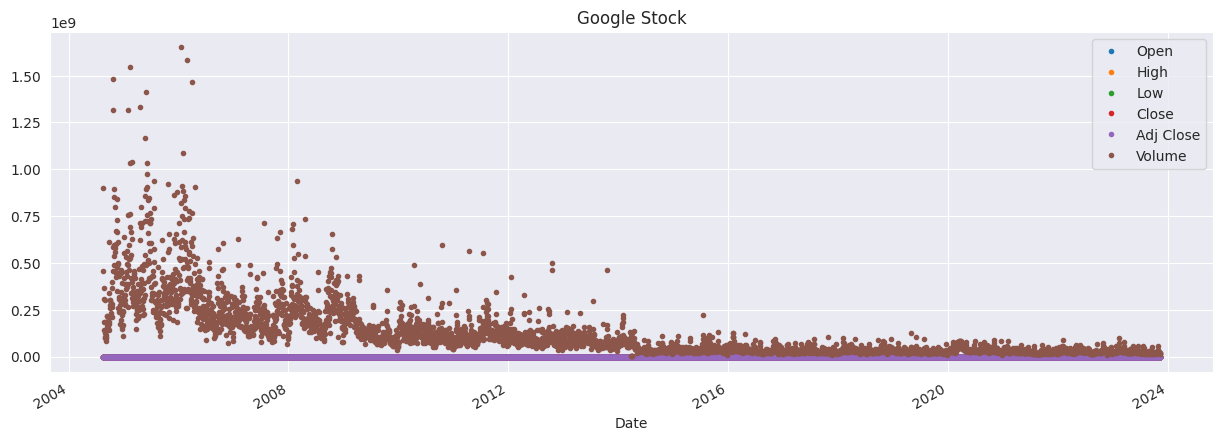

In [10]:
gs.plot(figsize=(15,5),style='.',title='Google Stock')

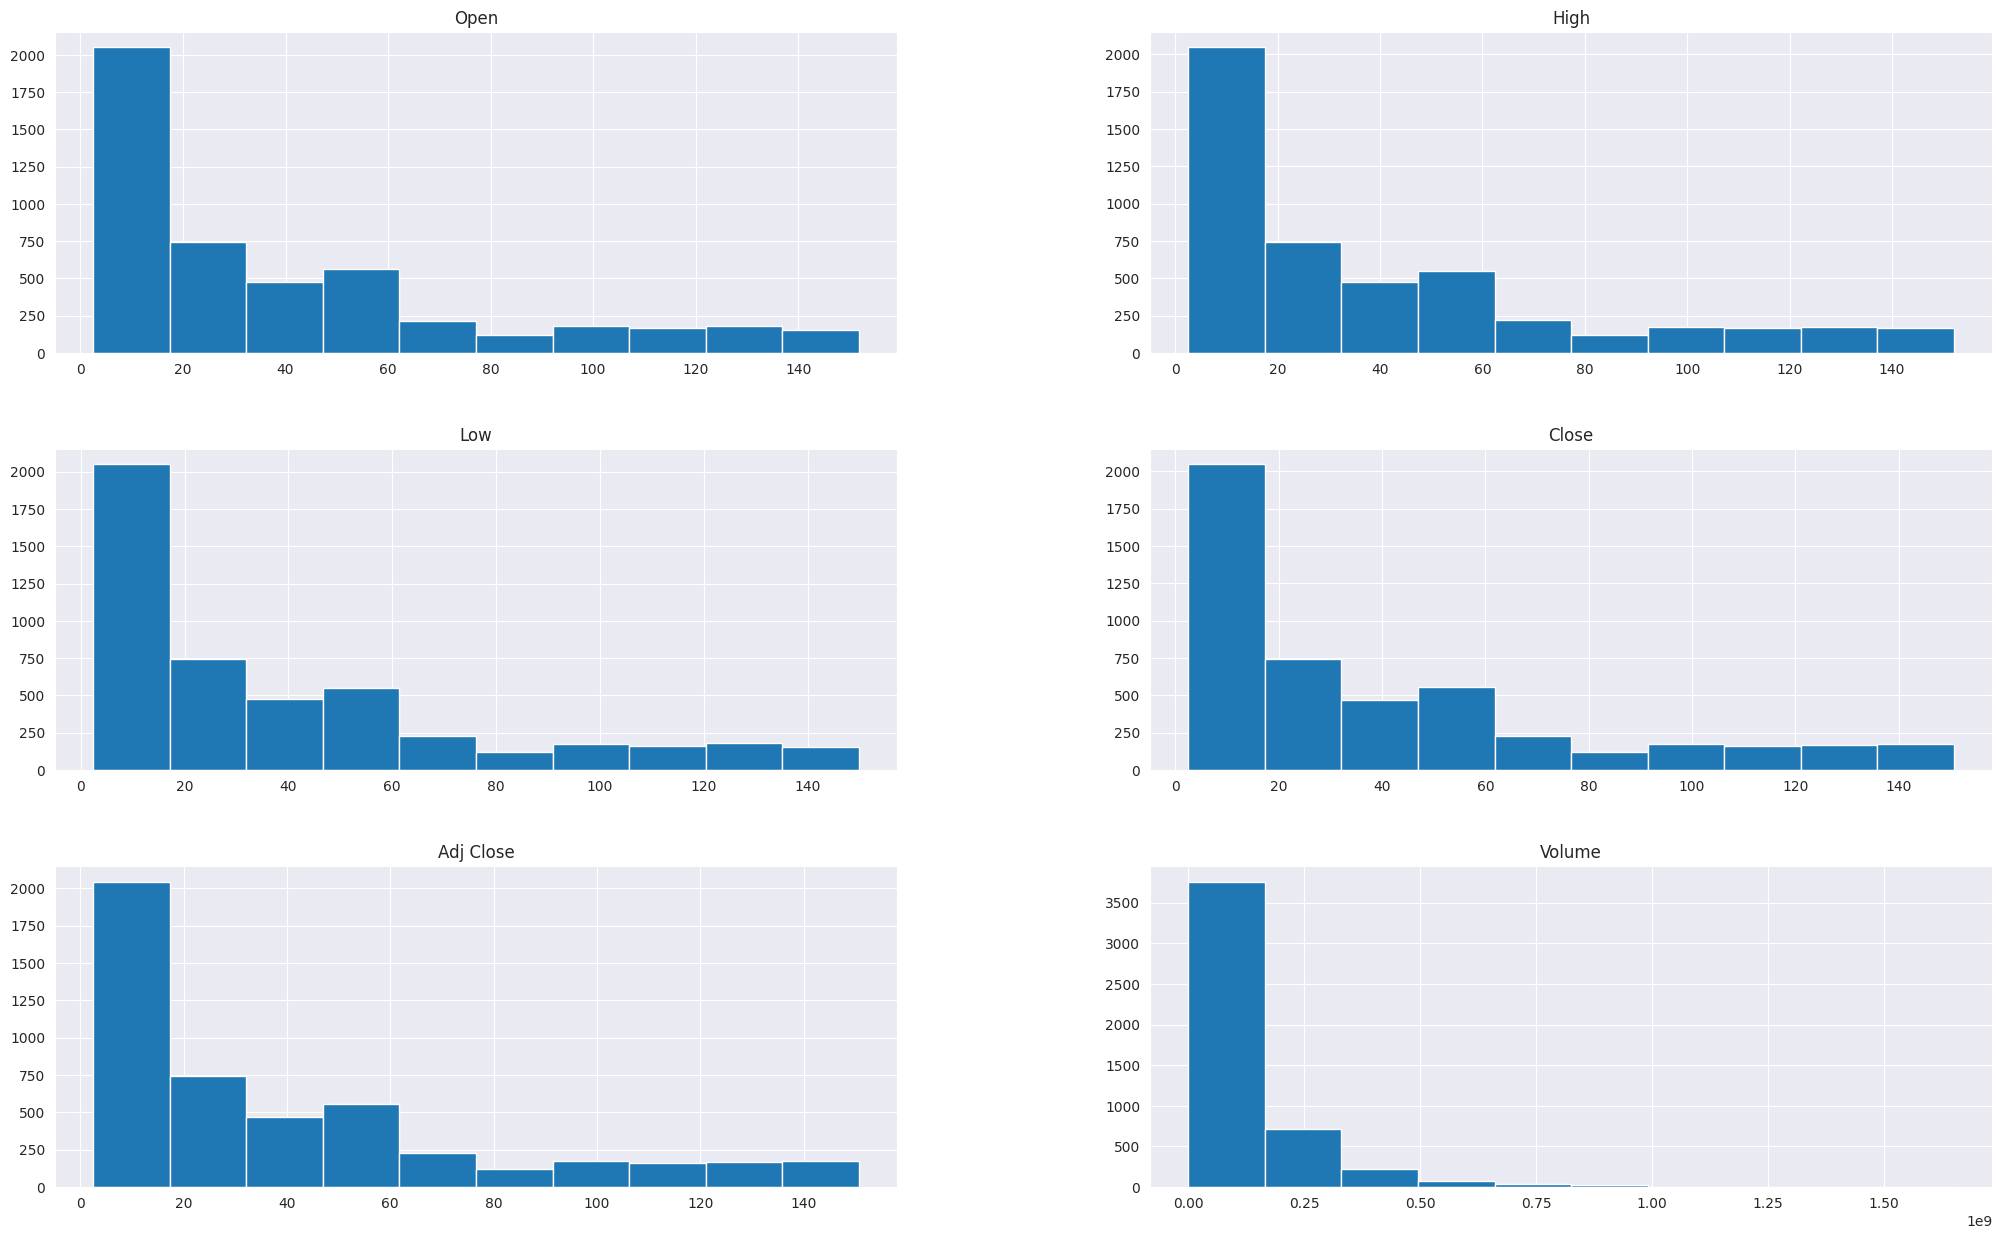

In [11]:
gs.hist(figsize=(25,15))
plt.show()

Text(0.5, 1.0, 'Stock Price of Google over the Years')

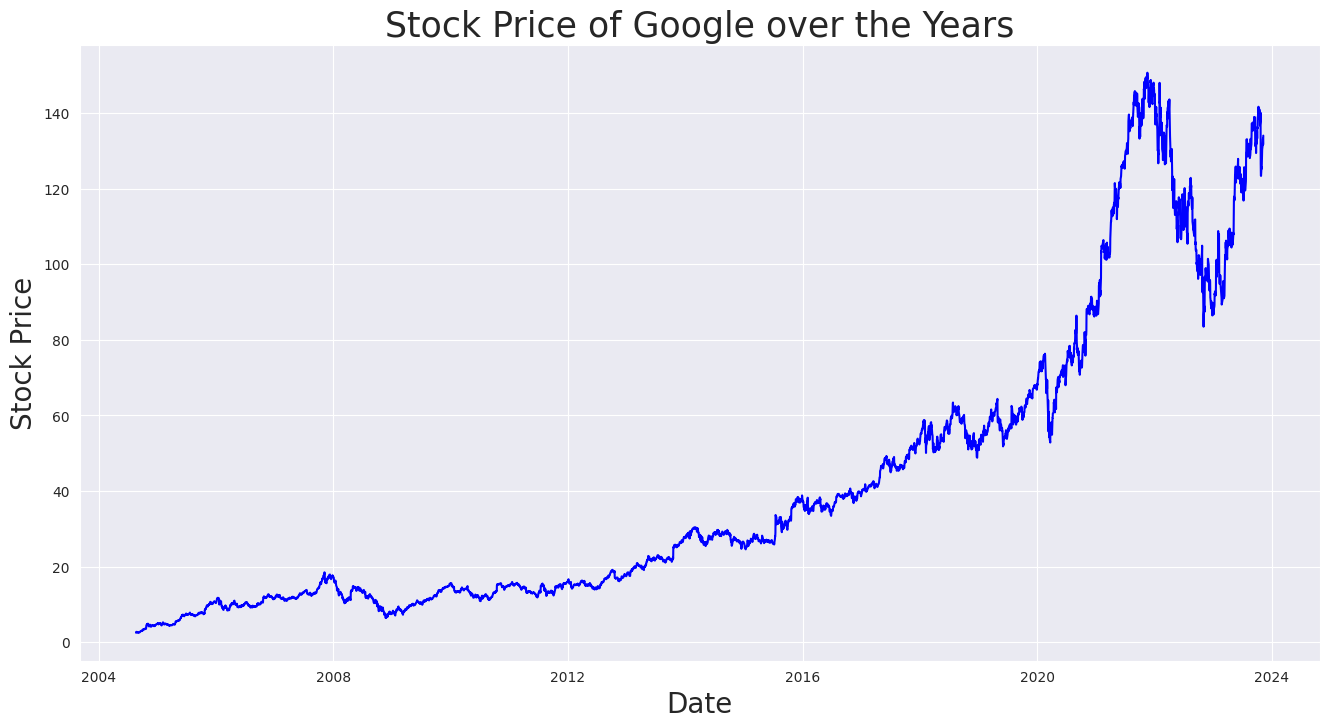

In [12]:
plt.figure(figsize=(16,8))
plt.plot(gs['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Google over the Years',size=25)

In [13]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Ohlc(x=gs.index, open=gs["Open"], high=gs["High"], low=gs["Low"], close=gs["Close"]))
fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title_text="OHLC Chart", title_x=0.5)
fig.show()

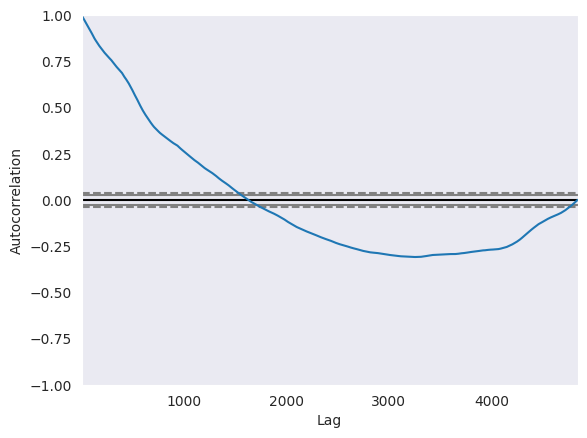

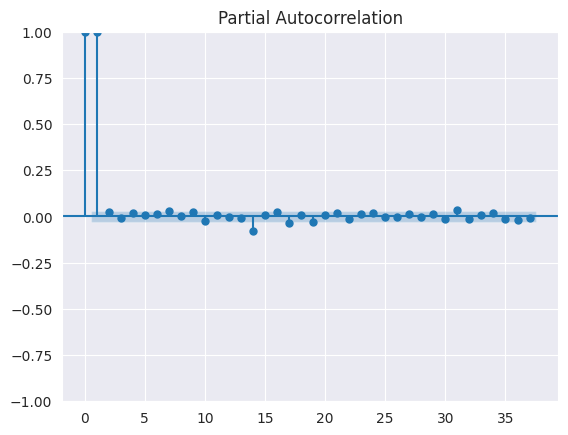

In [14]:
autocorrelation_plot(gs['Close'])
plot_pacf(gs['Close'])
plt.show()

In [15]:
def ad_test(dataset):
    gstest = adfuller(dataset, autolag = 'AIC')
    print('ADF:', gstest[0])
    print('P-value:', gstest[1])
    print('No. of lags:', gstest[2])
    print('Observation:', gstest[3])
    print('Critical values:')
    for key, val in gstest[4].items():
        print('\t', key, ':', val)
ad_test(gs['Close'])

ADF: 0.957710557932624
P-value: 0.9937990858288219
No. of lags: 31
Observation: 4810
Critical values:
	 1% : -3.4317102480761292
	 5% : -2.862141077334742
	 10% : -2.5670899550918262


In [16]:
data = gs['Close']
length = int(len(gs['Close']) * 0.90)
print('Length:', length)
print('Data length:',len(data))
train = data.iloc[:length]
print('training shape',train.shape)
test = data.iloc[length:]
print('testing shape',test.shape)

Length: 4357
Data length: 4842
training shape (4357,)
testing shape (485,)


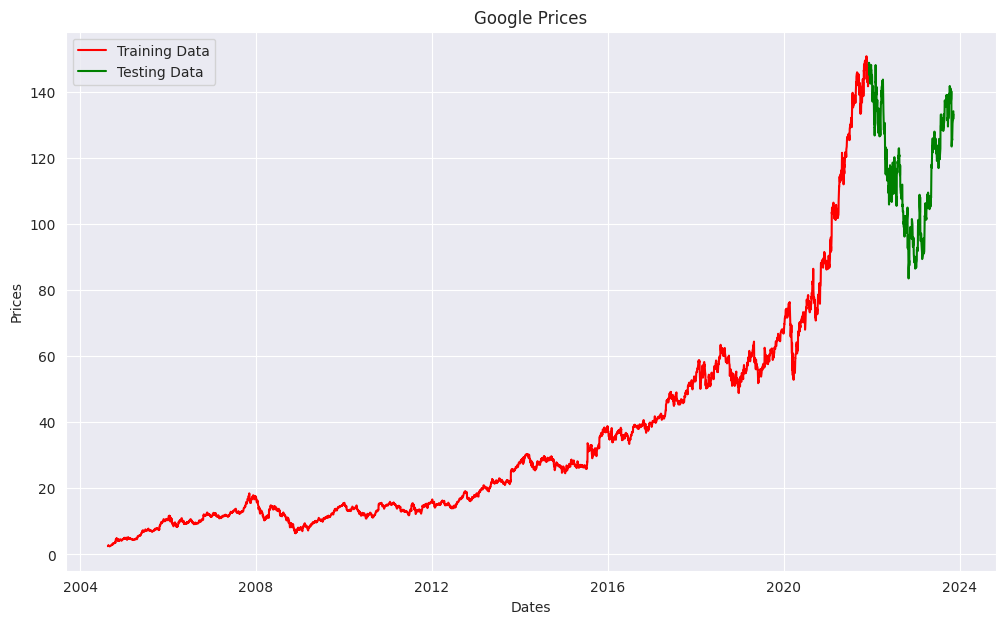

In [17]:
plt.figure(figsize=(12,7))
plt.title('Google Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train, 'red', label='Training Data')
plt.plot(test, 'green', label='Testing Data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9443.937, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9420.847, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9421.847, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9451.437, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9420.918, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9418.275, Time=1.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9420.253, Time=2.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9420.249, Time=3.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9422.008, Time=1.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9418.738, Time=5.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9426.806, Time=0.65 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.799 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 

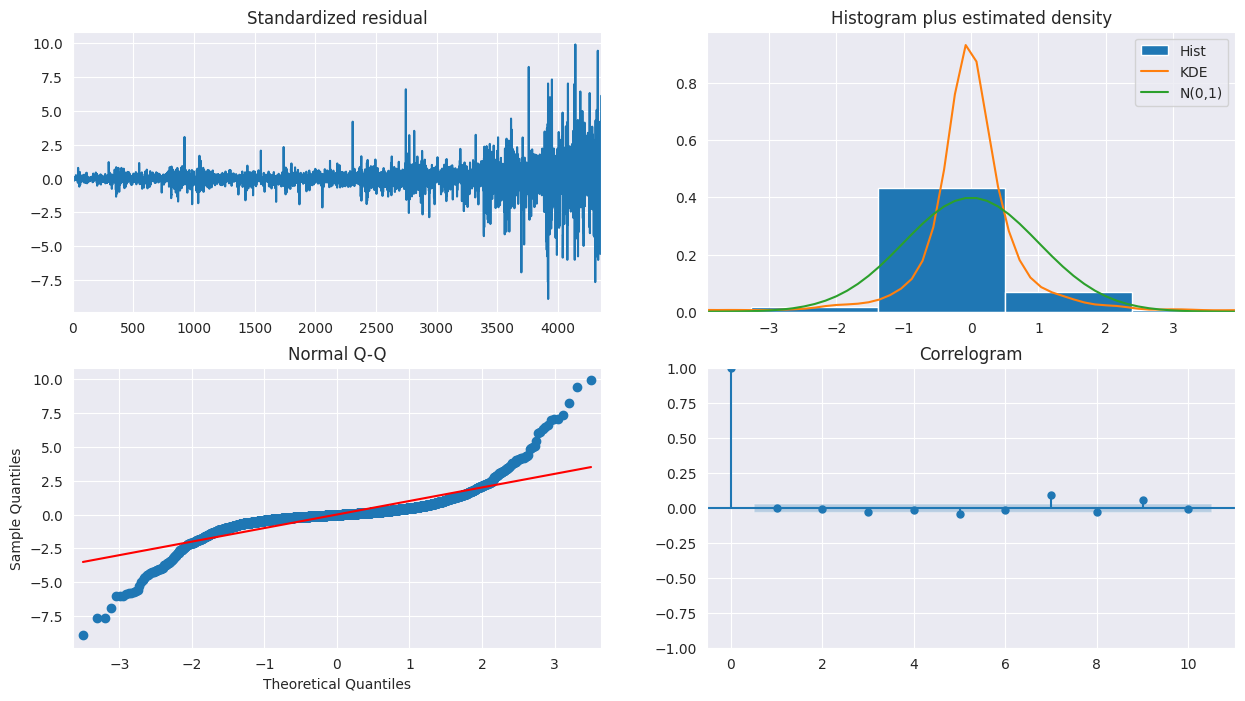

In [18]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [19]:
import statsmodels.api as sm
pred_start = test.index[0]
pred_end = test.index[-1]
model = sm.tsa.statespace.SARIMAX(data,order=(1,1,1))
model_fit = model.fit()
pred = model_fit.predict(start= pred_start , end = pred_end)
pred

Date
2021-12-08    147.921439
2021-12-09    148.598492
2021-12-10    148.023531
2021-12-13    148.584791
2021-12-14    146.696608
                 ...    
2023-11-06    130.365817
2023-11-07    131.408621
2023-11-08    132.331468
2023-11-09    133.171480
2023-11-10    131.669535
Name: predicted_mean, Length: 485, dtype: float64

<Axes: xlabel='Date'>

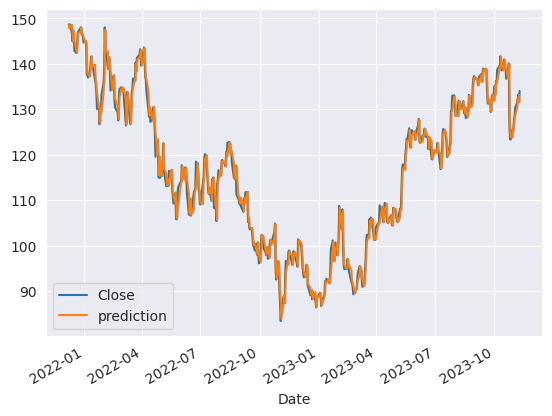

In [20]:
gs_sarimax = pd.DataFrame(test)
gs_sarimax["prediction"] = pd.Series(pred,index=test.index)
gs_sarimax.plot()

In [21]:
gs2 = pd.read_csv('/content/google_stock_price.csv')

In [23]:
gs_copy=gs2.copy()

In [24]:
import math
data = gs_copy.filter(['Close'])
dataset = data.values #convert the data frame to a numpy array
training_data_len = math.ceil(len(dataset)*.8)  # number of rows to train the model on
training_data_len

3874

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[5.54601395e-05],
       [1.39474256e-03],
       [1.57790515e-03],
       ...,
       [8.82274792e-01],
       [8.71682346e-01],
       [8.87672264e-01]])

In [26]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([5.54601395e-05, 1.39474256e-03, 1.57790515e-03, 8.16681841e-04,
       1.00656502e-03, 1.32752381e-03, 1.03177125e-03, 3.36085743e-04,
       3.96579086e-04, 4.03331846e-05, 2.52062297e-04, 0.00000000e+00,
       2.63827349e-04, 3.84818860e-04, 3.86498202e-04, 8.93979873e-04,
       1.25862571e-03, 1.92911142e-03, 2.01480938e-03, 2.34584744e-03,
       2.93735417e-03, 3.25158754e-03, 2.99616656e-03, 3.08690416e-03,
       3.49692925e-03, 3.33056652e-03, 3.06674561e-03, 4.51189259e-03,
       5.22102410e-03, 4.97232210e-03, 5.47308479e-03, 5.88982081e-03,
       6.44603560e-03, 6.22926685e-03, 6.52669393e-03, 6.33849170e-03,
       5.92343341e-03, 6.28303960e-03, 6.87117960e-03, 7.05602153e-03,
       7.41058809e-03, 8.25919514e-03, 8.05418662e-03, 6.80228150e-03,
       8.29616160e-03, 1.21695001e-02, 1.46850625e-02, 1.37440385e-02,
       1.44447685e-02, 1.56765022e-02, 1.52295171e-02, 1.61352524e-02,
       1.59403296e-02, 1.54025956e-02, 1.42313536e-02, 1.16519311e-02,
     

In [29]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(loss='binary_crossentropy',optimizer='Adam')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
120/120 [==============================] - 18s 109ms/step - loss: 0.3837
Epoch 2/100
120/120 [==============================] - 13s 108ms/step - loss: 0.3768
Epoch 3/100
120/120 [==============================] - 13s 108ms/step - loss: 0.3768
Epoch 4/100
120/120 [==============================] - 13s 109ms/step - loss: 0.3765
Epoch 5/100
120/120 [==============================] - 18s 152ms/step - loss: 0.3765
Epoch 6/100
120/120 [==============================] - 25s 212ms/step - loss: 0.3764
Epoch 7/100
120/120 [==============================] - 15s 127ms/step - loss: 0.3764
Epoch 8/100
120/120 [==============================] - 13s 107ms/step - loss: 0.3764
Epoch 9/100
120/120 [==============================] - 13s 108ms/step - loss: 0.3764
Epoch 10/100
120/120 [==============================] - 13s 108ms/step - loss: 0.3763
Epoch 11/100
120/120 [==============================] - 13s 107ms/step - loss: 0.3764
Epoch 12/100
120/120 [==============================] - 13s 108

In [30]:
from sklearn.metrics import mean_absolute_error


test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("RMSE: {:.4f}".format(rmse))
print("MAE: {:.4f}".format(mae))
print("MSE: {:.4f}".format(mse))
print("R2 Score: {:.4f}".format(r2))

31/31 [==============================] - 2s 35ms/step
RMSE: 7.2400
MAE: 5.4124
MSE: 52.4176
R2 Score: 0.9175


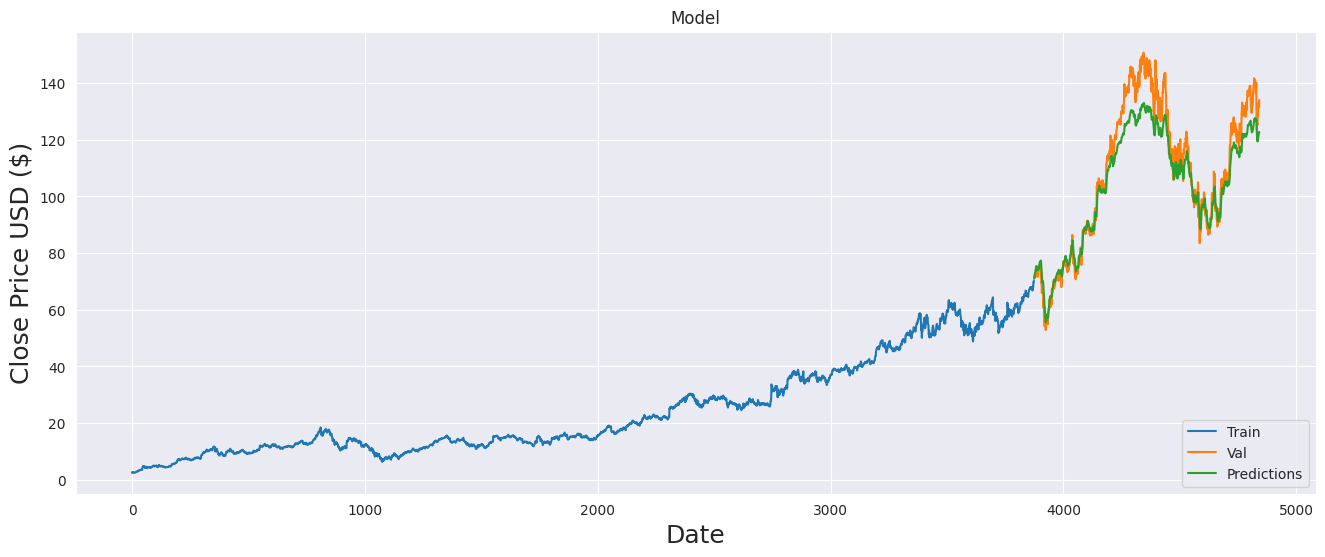

In [31]:
train = data[:training_data_len]
val = data[training_data_len:]
val['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(val[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [32]:
val

,Close,Predictions
3874,70.991501,71.021347
3875,71.486504,71.583038
3876,71.961502,72.130203
3877,71.543999,72.649132
3878,71.959999,72.870857
...,...,...
4837,131.449997,121.084679
4838,132.399994,121.694176
4839,133.259995,122.248718
4840,131.690002,122.755394
